## Beep making
### exercise 4: ADDITIVE RESYNTHESIS
### (LIGO data example)

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

# from the y21 notebook-- do we need these?
from subprocess import Popen
import subprocess as sp
import os

import pandas as pd

import pywt
import resampy as rp

import IPython.display as ipd

from funcs import bips as bip
from funcs import notepicker


In [98]:
# READ IN THE DATA FILE 
print(os.listdir(os.path.abspath('./data/LIGO/')))
 
datafilename = './data/LIGO/obs_LivingstonLA.txt'      

data = np.loadtxt(datafilename)
print(np.shape(data))
x = data[:, 0]
x = x - x[0]  # make time start at zero
y = data[:, 1]  

['obs_LivingstonLA.txt', '.ipynb_checkpoints', 'obs_HanfordWA.txt']
(3441, 2)


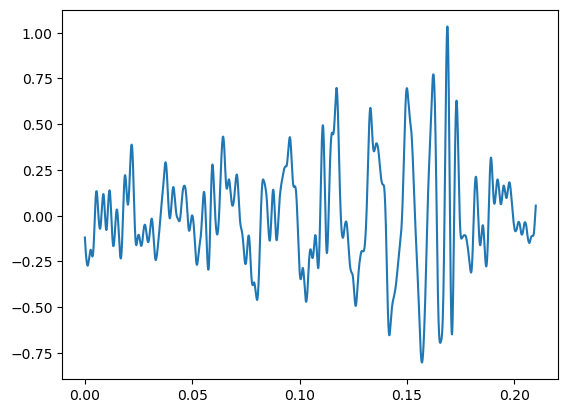

In [99]:
plt.plot(x,y)

In [126]:
# direct sonification of the chirp signal: 
ipd.Audio(y, rate=int(fs)) 

original sampling frequency = 16384.0


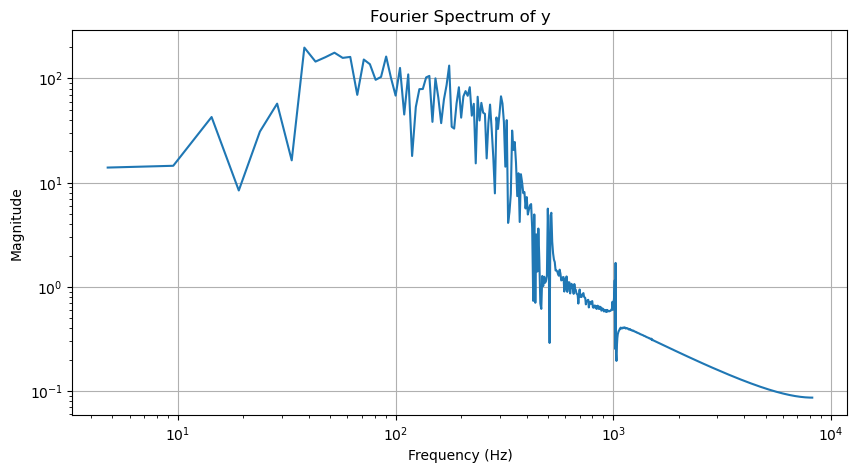

In [115]:
# Plot the Fourier spectrum (magnitude) of the entire signal y

# Compute the FFT
Y = np.fft.fft(y)
N = len(y)
fs = 1/(x[1] - x[0])  # Sampling frequency
print(f'original sampling frequency = {fs}')
freqs = np.fft.fftfreq(N, d=(x[1] - x[0]))

# Only keep the positive frequencies
idx = np.where(freqs > 0)

plt.figure(figsize=(10, 5))
plt.plot(freqs[idx], np.abs(Y[idx]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Fourier Spectrum of y')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

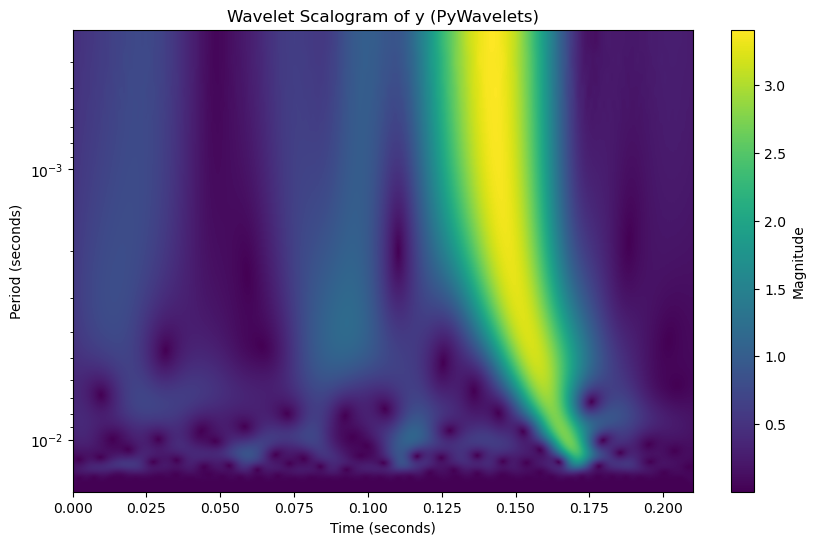

In [132]:
# Wavelet transform and periodogram plot for y using PyWavelets



# Choose a wavelet and scales
wavelet = 'cmor1.5-1.0'  # Complex Morlet, good for time-frequency
scales = np.arange(5, 256)
#scales = np.arange(100, 2*256)

# Perform the continuous wavelet transform (CWT)
coefficients, frequencies = pywt.cwt(y, scales, wavelet, sampling_period=(x[1]-x[0]))

# Compute the periodogram (power spectrum)
power = (np.abs(coefficients) ** 2).mean(axis=1)

# Plot the wavelet scalogram (time-frequency representation) using PyWavelets

# coefficients, frequencies already computed above
scalomat = np.abs(coefficients)

plt.figure(figsize=(10, 6))
plt.imshow(scalomat, aspect='auto', extent=[x[0], x[-1], 1/frequencies[-1], 1/frequencies[0]],
           cmap='viridis', origin='lower')
plt.colorbar(label='Magnitude')
plt.xlabel('Time (seconds)')
plt.ylabel('Period (seconds)')
plt.title('Wavelet Scalogram of y (PyWavelets)')
plt.yscale('log')
plt.show()

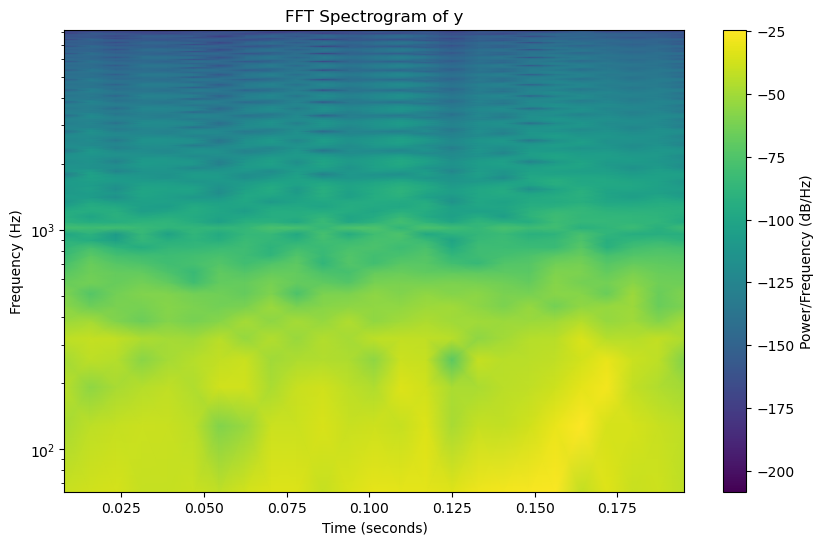

In [25]:
# # Calculate and plot the FFT spectrogram of y
# import matplotlib.pyplot as plt
# from scipy.signal import spectrogram

# # Calculate the spectrogram
# fs = 1/(x[1] - x[0])  # Sampling frequency from time array
# f, t, Sxx = spectrogram(y, fs=fs, nperseg=256, noverlap=128)

# # Plot the spectrogram
# plt.figure(figsize=(10, 6))
# plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='viridis')
# plt.ylabel('Frequency (Hz)')
# plt.xlabel('Time (seconds)')
# plt.title('FFT Spectrogram of y')
# plt.colorbar(label='Power/Frequency (dB/Hz)')
# plt.yscale('log')
# plt.ylim([f[1], f[-1]])
# plt.show()

In [133]:
# the scalogram looks much clearer in the chirp than the spectrogram
# so lets use the scalogram to make the envelopes.. 
periods = 1/frequencies
#print(periods)
print(len(periods))
perds4oscbank = np.linspace(3,9,6)*1e-3  # seconds
print(perds4oscbank)

251
[0.003  0.0042 0.0054 0.0066 0.0078 0.009 ]


In [134]:
# Find the indexes of the nearest values in 'periods' for each value in 'perds4oscbank'
nearest_idxs = [np.abs(periods - val).argmin() for val in perds4oscbank]
selected_periods = periods[nearest_idxs]
freqs = 1/selected_periods
print('Indexes of nearest periods:', nearest_idxs)
print('Nearest period values:', selected_periods)
print('Frequencies:', freqs)

Indexes of nearest periods: [44, 64, 83, 103, 123, 142]
Nearest period values: [0.00299072 0.00421143 0.00537109 0.0065918  0.0078125  0.00897217]
Frequencies: [334.36734694 237.44927536 186.18181818 151.7037037  128.
 111.45578231]


(6, 3441)
Selected period: 0.002991 seconds at index 44
Selected period: 0.004211 seconds at index 64
Selected period: 0.005371 seconds at index 83
Selected period: 0.006592 seconds at index 103
Selected period: 0.007812 seconds at index 123
Selected period: 0.008972 seconds at index 142


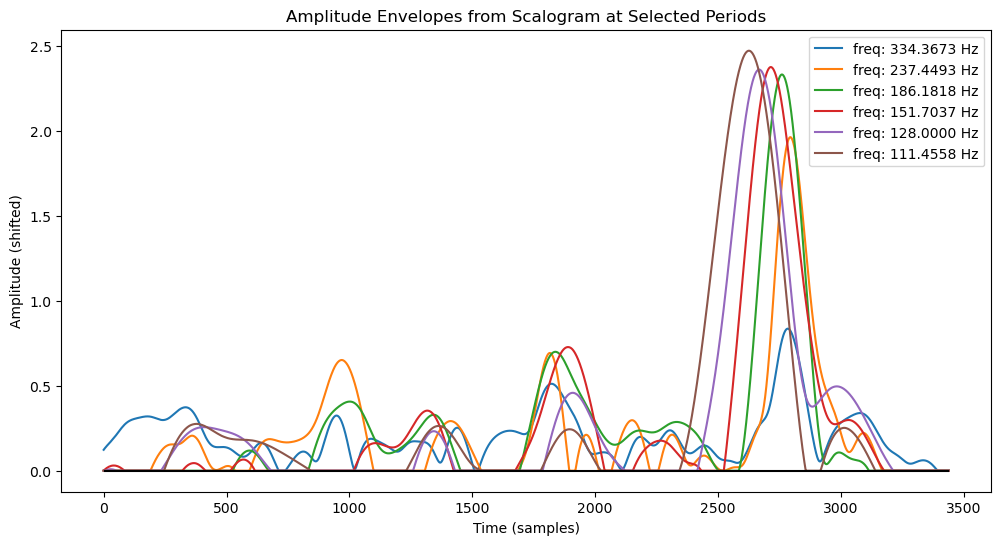

In [136]:
shift = 0.2
env_amp_mat = np.zeros((len(nearest_idxs), len(scalomat[0,:])))
print(np.shape(env_amp_mat))
for i,idx in enumerate(nearest_idxs):
    print(f"Selected period: {periods[idx]:.6f} seconds at index {idx}")
    env_amp_mat[i,:]= scalomat[idx,:]-np.mean(scalomat[idx,:])+shift
# remove any values less than zero:
env_amp_mat[env_amp_mat < 0] = 0

plt.figure(figsize=(12, 6))
for i in range(env_amp_mat.shape[0]):
    #plt.plot(env_amp_mat[i, :], label=f'Period: {periods[nearest_idxs[i]]:.6f} s')
    plt.plot(env_amp_mat[i, :], label=f'freq: {1/periods[nearest_idxs[i]]:.4f} Hz')
plt.hlines(0, 0, env_amp_mat.shape[1], colors='black')
plt.title('Amplitude Envelopes from Scalogram at Selected Periods')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (shifted)')
plt.legend()
plt.show()

In [137]:
# now resample the envelopes to audio rate and use them to modulate sine wave oscillators
sr_audio = 44100  # audio sample rate
dur = 6  # duration, seconds
num_samples = int(sr_audio * dur)
time_rs = np.linspace(0, x[-1] , num_samples)
env_amp_mat_rs = np.zeros((env_amp_mat.shape[0], num_samples))
print(np.shape(env_amp_mat_rs))

sr_orig = 1/(x[1]-x[0])  # original sample rate of data
for i in range(env_amp_mat.shape[0]):
    env_amp_mat_rs[i, :] = np.interp(time_rs, x, env_amp_mat[i, :])
    #env_amp_mat_rs[i, :] = rp.resample(env_amp_mat[i, :], fs, 44100) 
# y_low = resampy.resample(x, sr_orig, 16000)
# call the bip function to make the oscillators and mix them down

(6, 264600)


In [138]:

b = bip.beep()
b.make_bip(dur, freqs, env_amp_mat_rs)
wf = b.wf/(np.max(np.abs(b.wf))) # normalize
# taper the waveform: 
wf = bip.taper_waveform(wf, alpha=0.05)



/Users/ben/githole/datamovies_ppy26/funcs/bips.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  self.oscmat[ifrx,:] = np.exp(1j*2*np.pi*f*self.t_vec) * self.env_amps[ifrx,:]


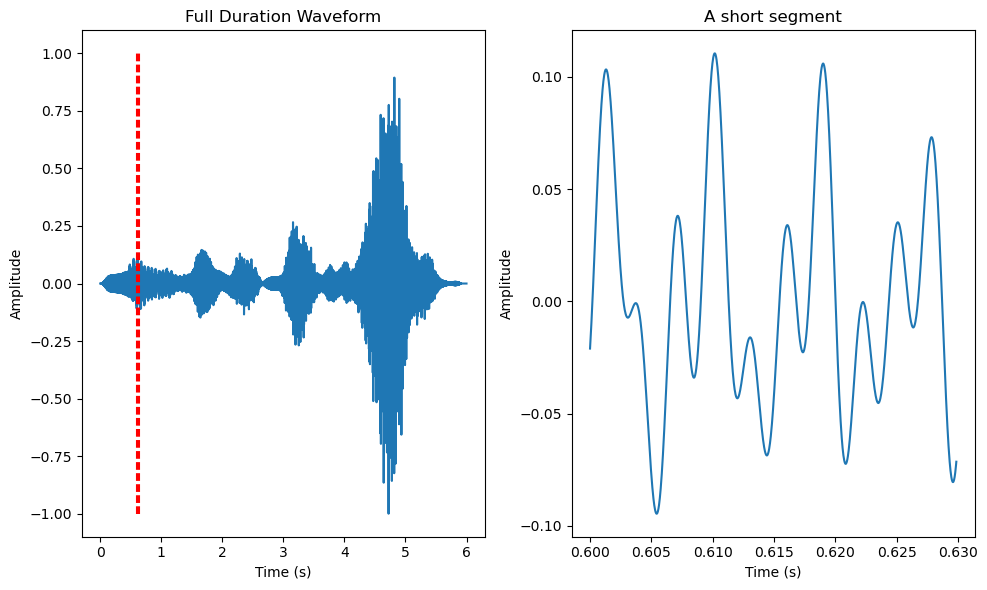

In [140]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Plot a few oscillations first, then the whole waveform
start = int(0.1*len(wf))
end = start + int(10*(1/freqs[0])*44100)  # First 4 cycles (samples)
t_short = b.t_vec[start:end]  # First 100 samples
wf_short = wf[start:end]

# call the function with the existing variables
bip.plot_waveforms(ax1, ax2, t_short, wf_short, b.t_vec, wf)
plt.tight_layout()
plt.show()

ipd.Audio(wf, rate=sr_audio)